In [ ]:
# Instalujemy bibliotekę, która ułatwi nam ewaluację modelu
!pip install torchmetrics -q
!pip install pycocotools -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
#from google.colab import drive

# Montujemy Dysk Google
drive.mount('/content/drive')

# Definiujemy ścieżki do naszych danych
# Upewnij się, że te ścieżki są dokładnie takie same jak na Twoim Dysku
IMAGES_PATH = '/content/drive/MyDrive/my-detector/dataset/images'
ANNOTATIONS_PATH = '/content/drive/MyDrive/my-detector/dataset/voc_xml'

# Prosty test, aby sprawdzić, czy mamy dostęp do folderów
# i ile plików się w nich znajduje
print(f"Znaleziono {len(os.listdir(IMAGES_PATH))} obrazów w folderze images.")
print(f"Znaleziono {len(os.listdir(ANNOTATIONS_PATH))} adnotacji w folderze annotations.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Znaleziono 50 obrazów w folderze images.
Znaleziono 50 adnotacji w folderze annotations.


Wybrany obraz: object_img043.jpg
Wybrana adnotacja: object_img043.xml

Znaleziona klasa: 'object' ze współrzędnymi: (125, 62), (278, 175)


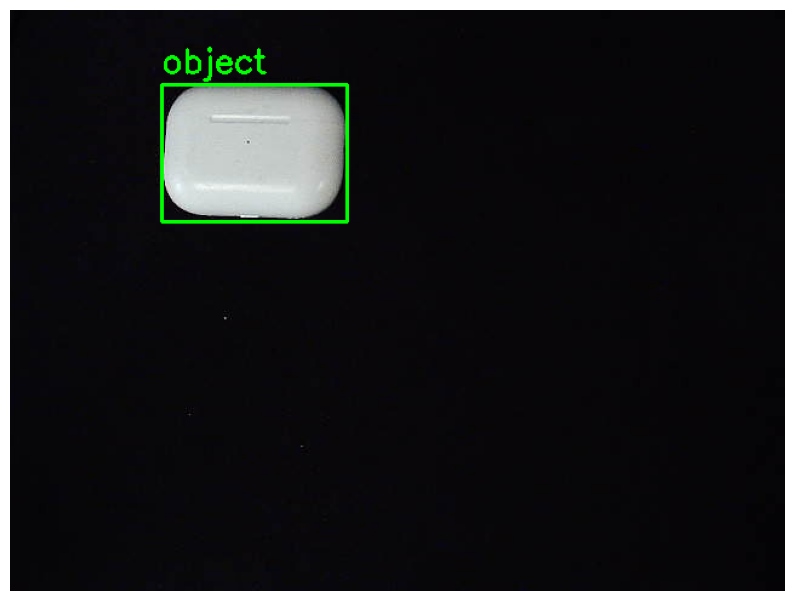

In [ ]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import random

# Pobieramy listy plików
image_files = sorted(os.listdir(IMAGES_PATH))
annotation_files = sorted(os.listdir(ANNOTATIONS_PATH))

# Wybieramy losowy indeks, aby zwizualizować przykład
random_index = random.randint(0, len(image_files) - 1)
selected_image_name = image_files[random_index]
# Zakładamy, że plik XML ma taką samą nazwę (bez rozszerzenia) jak plik JPG
selected_annotation_name = selected_image_name.replace('.jpg', '.xml')

# Pełne ścieżki do plików
image_path = os.path.join(IMAGES_PATH, selected_image_name)
annotation_path = os.path.join(ANNOTATIONS_PATH, selected_annotation_name)

print(f"Wybrany obraz: {selected_image_name}")
print(f"Wybrana adnotacja: {selected_annotation_name}\n")

# Parsowanie pliku XML
tree = ET.parse(annotation_path)
root = tree.getroot()

# Wyciągamy współrzędne ramki (bounding box)
for member in root.findall('object'):
    class_name = member.find('name').text

    # Współrzędne ramki
    xmin = int(member.find('bndbox').find('xmin').text)
    ymin = int(member.find('bndbox').find('ymin').text)
    xmax = int(member.find('bndbox').find('xmax').text)
    ymax = int(member.find('bndbox').find('ymax').text)

    print(f"Znaleziona klasa: '{class_name}' ze współrzędnymi: ({xmin}, {ymin}), ({xmax}, {ymax})")

# Wczytujemy obraz za pomocą OpenCV
image = cv2.imread(image_path)
# Konwertujemy kolory z BGR (standard OpenCV) na RGB (standard matplotlib)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Rysujemy prostokąt na obrazie
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)
# Dodajemy tekst z nazwą klasy
cv2.putText(image, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Wyświetlamy obraz
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# --- Część 1: Definicja mapowania klas ---
# Tworzymy mapowanie nazw klas na liczby całkowite.
# 0 jest zarezerwowane dla tła, więc nasza pierwsza klasa ma numer 1.
CLASS_NAMES = ["__background__", "object"]
# Tworzymy słownik dla łatwego dostępu
class_map = {name: i for i, name in enumerate(CLASS_NAMES)}

# --- Część 2: Definicja niestandardowej klasy Dataset ---
class ObjectDetectionDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, class_map, transforms=None):
        super().__init__()
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.class_map = class_map
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        annotation_path = self.annotation_paths[idx]

        # Wczytujemy obraz
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Parsujemy adnotacje XML
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for member in root.findall('object'):
            class_name = member.find('name').text

            # Konwertujemy nazwę klasy na jej numeryczny odpowiednik
            label = self.class_map[class_name]

            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Konwertujemy listy na tensory PyTorch
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Tworzymy słownik "target", zgodnie z wymaganiami modeli torchvision
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # Stosujemy transformacje (augmentacje), jeśli są zdefiniowane
        if self.transforms:
            # W przyszłości dodamy tu transformacje z biblioteki Albumentations
            # Na razie konwertujemy obraz do tensora
            image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0

        return image, target

# --- Część 3: Przygotowanie i podział danych ---
# Tworzymy pełne ścieżki do plików
image_filenames = sorted(os.listdir(IMAGES_PATH))
all_image_paths = [os.path.join(IMAGES_PATH, fname) for fname in image_filenames]
all_annotation_paths = [os.path.join(ANNOTATIONS_PATH, fname.replace('.jpg', '.xml')) for fname in image_filenames]

# Dzielimy dane na zbiór treningowy i walidacyjny (np. 80% trening, 20% walidacja)
train_img_paths, val_img_paths, train_ann_paths, val_ann_paths = train_test_split(
    all_image_paths, all_annotation_paths, test_size=0.2, random_state=42
)

# --- Część 4: Utworzenie instancji Dataset ---
# Na razie bez transformacji (dodamy je później)
train_dataset = ObjectDetectionDataset(train_img_paths, train_ann_paths, class_map, transforms=True)
val_dataset = ObjectDetectionDataset(val_img_paths, val_ann_paths, class_map, transforms=True)

print(f"Rozmiar zbioru treningowego: {len(train_dataset)}")
print(f"Rozmiar zbioru walidacyjnego: {len(val_dataset)}")

# Sprawdźmy jedną próbkę z naszego datasetu
img, tgt = train_dataset[0]
print("\nPrzykładowa próbka z Datasetu:")
print("Kształt tensora obrazu:", img.shape)
print("Typ danych tensora obrazu:", img.dtype)
print("Zawartość targetu:", tgt)

Rozmiar zbioru treningowego: 40
Rozmiar zbioru walidacyjnego: 10

Przykładowa próbka z Datasetu:
Kształt tensora obrazu: torch.Size([3, 480, 640])
Typ danych tensora obrazu: torch.float32
Zawartość targetu: {'boxes': tensor([[229., 142., 386., 259.]]), 'labels': tensor([1])}


In [ ]:
import torch
import torchvision
from torch import nn # <-- WAŻNE: Potrzebujemy tego importu
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels

# Załóżmy, że CLASS_NAMES jest już zdefiniowane
# Przykładowa definicja dla celów demonstracyjnych:
CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3']

# --- Część 1: Ładowanie wstępnie wytrenowanego modelu ---
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='DEFAULT')

# --- Część 2: Modyfikacja głowicy klasyfikacyjnej ---
# Pobieramy liczbę klas
num_classes = len(CLASS_NAMES)

# Pobieramy liczbę kanałów wejściowych dla głowicy
in_channels = retrieve_out_channels(model.backbone, (320, 320))

# Pobieramy liczbę kotwic (anchors)
num_anchors = model.anchor_generator.num_anchors_per_location()

# Definiujemy warstwę normalizacyjną, której wymaga nowa głowica
# Najczęściej będzie to standardowa warstwa BatchNorm2d
norm_layer = nn.BatchNorm2d

# Tworzymy nową głowicę klasyfikacyjną z dodatkowym argumentem 'norm_layer'
model.head.classification_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=norm_layer  # <-- POPRAWKA: Dodajemy brakujący argument
)


# --- Część 3: Przeniesienie modelu na GPU (jeśli dostępne) ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print("Model SSDLite320_MobileNet_V3_Large został pomyślnie załadowany i zmodyfikowany.")
print(f"Model został przeniesiony na urządzenie: {device}")

# Opcjonalnie: wyświetlmy strukturę głowicy
print("\nStruktura zmodyfikowanej głowicy klasyfikacyjnej:")
print(model.head.classification_head)

Model SSDLite320_MobileNet_V3_Large został pomyślnie załadowany i zmodyfikowany.
Model został przeniesiony na urządzenie: cuda

Struktura zmodyfikowanej głowicy klasyfikacyjnej:
SSDLiteClassificationHead(
  (module_list): ModuleList(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=672, bias=False)
        (1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(672, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
        (1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(480, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Sequential(
      (0): Conv2dNorm

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR # Do schedulera
from tqdm.notebook import tqdm # Do pasków postępu
from torchmetrics.detection.mean_ap import MeanAveragePrecision # Do metryki mAP
import copy # Do zapisywania najlepszych wag

# --- Założenia (ten kod jest już u Ciebie) ---
# model = ... (załadowany i zmodyfikowany model SSDLite)
# train_dataset, val_dataset = ... (przygotowane datasety)
# device = ... (ustawione urządzenie 'cuda' lub 'cpu')
# ---------------------------------------------------

def collate_fn(batch):
    return tuple(zip(*batch))

# Tworzymy DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Definiujemy optymalizator
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

# Definiujemy scheduler, który obniży learning rate co 5 epok
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Inicjalizujemy metrykę mAP
# Używamy formatu 'xyxy' dla bounding boxów, co jest standardem w torchvision
map_metric = MeanAveragePrecision(box_format='xyxy').to(device)

# Liczba epok treningu
num_epochs = 20

# Zmienne do śledzenia najlepszego modelu
best_map = 0.0
best_model_weights = None

print("Rozpoczynamy trening...")
print("---------------------------------")

for epoch in range(num_epochs):
    # --- Faza treningu ---
    model.train()
    total_train_loss = 0

    # Pętla treningowa z paskiem postępu
    for images, targets in tqdm(train_loader, desc=f"Epoka {epoch+1}/{num_epochs} [Trening]"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # W trybie .train() model zwraca słownik strat
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Faza walidacji ---
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        # Pętla walidacyjna z paskiem postępu
        for images, targets in tqdm(val_loader, desc=f"Epoka {epoch+1}/{num_epochs} [Walidacja]"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # W trybie .eval() model zwraca predykcje
            predictions = model(images)

            # Aby obliczyć stratę walidacyjną, musimy na chwilę przełączyć model w tryb .train()
            # i przekazać mu również etykiety. Działamy wewnątrz torch.no_grad(),
            # więc gradienty nie będą liczone.
            model.train()
            loss_dict_val = model(images, targets)
            model.eval() # Wracamy do trybu ewaluacji

            val_losses = sum(loss for loss in loss_dict_val.values())
            total_val_loss += val_losses.item()

            # Aktualizujemy stan metryki mAP o predykcje i prawdziwe etykiety z tego batcha
            map_metric.update(predictions, targets)

    avg_val_loss = total_val_loss / len(val_loader)

    # Obliczamy końcowe mAP dla całej epoki
    map_results = map_metric.compute()
    map_metric.reset() # Resetujemy metrykę na następną epokę

    # Aktualizujemy learning rate
    lr_scheduler.step()

    # Wyświetlanie wyników epoki
    print(
        f"Epoka {epoch+1}/{num_epochs} | "
        f"Strata treningowa: {avg_train_loss:.4f} | "
        f"Strata walidacyjna: {avg_val_loss:.4f} | "
        f"mAP: {map_results['map']:.4f} | "
        f"mAP_50: {map_results['map_50']:.4f}"
    )

    # Zapisywanie najlepszego modelu na podstawie mAP
    if map_results['map'] > best_map:
        best_map = map_results['map']
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"🎉 Nowy najlepszy model znaleziony! mAP: {best_map:.4f}. Zapisuję wagi.")


print("---------------------------------")
print("Trening zakończony!")

# Zapisanie wag najlepszego modelu do pliku
if best_model_weights:
    torch.save(best_model_weights, 'best_object_detection_model.pth')
    print("\nWagi najlepszego modelu zostały zapisane w pliku 'best_object_detection_model.pth'")

Rozpoczynamy trening...
---------------------------------


Epoka 1/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 1/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoka 1/20 | Strata treningowa: 5.7756 | Strata walidacyjna: 3.0139 | mAP: 0.8043 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.8043. Zapisuję wagi.


Epoka 2/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 2/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 2/20 | Strata treningowa: 1.9855 | Strata walidacyjna: 1.2581 | mAP: 0.8934 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.8934. Zapisuję wagi.


Epoka 3/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 3/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 3/20 | Strata treningowa: 0.8292 | Strata walidacyjna: 0.6692 | mAP: 0.8912 | mAP_50: 1.0000


Epoka 4/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 4/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 4/20 | Strata treningowa: 0.4459 | Strata walidacyjna: 0.4574 | mAP: 0.8741 | mAP_50: 1.0000


Epoka 5/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 5/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 5/20 | Strata treningowa: 0.2762 | Strata walidacyjna: 0.4262 | mAP: 0.8541 | mAP_50: 1.0000


Epoka 6/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 6/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 6/20 | Strata treningowa: 0.1878 | Strata walidacyjna: 0.3089 | mAP: 0.9183 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9183. Zapisuję wagi.


Epoka 7/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 7/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 7/20 | Strata treningowa: 0.1531 | Strata walidacyjna: 0.3021 | mAP: 0.8953 | mAP_50: 1.0000


Epoka 8/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 8/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 8/20 | Strata treningowa: 0.1262 | Strata walidacyjna: 0.2910 | mAP: 0.9228 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9228. Zapisuję wagi.


Epoka 9/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 9/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 9/20 | Strata treningowa: 0.1055 | Strata walidacyjna: 0.3180 | mAP: 0.9238 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9238. Zapisuję wagi.


Epoka 10/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 10/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 10/20 | Strata treningowa: 0.0912 | Strata walidacyjna: 0.3194 | mAP: 0.9104 | mAP_50: 1.0000


Epoka 11/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 11/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 11/20 | Strata treningowa: 0.0821 | Strata walidacyjna: 0.3069 | mAP: 0.9252 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9252. Zapisuję wagi.


Epoka 12/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 12/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 12/20 | Strata treningowa: 0.0781 | Strata walidacyjna: 0.2849 | mAP: 0.9252 | mAP_50: 1.0000


Epoka 13/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 13/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 13/20 | Strata treningowa: 0.0753 | Strata walidacyjna: 0.3161 | mAP: 0.9316 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9316. Zapisuję wagi.


Epoka 14/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 14/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 14/20 | Strata treningowa: 0.0742 | Strata walidacyjna: 0.2912 | mAP: 0.9324 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9324. Zapisuję wagi.


Epoka 15/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 15/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 15/20 | Strata treningowa: 0.0678 | Strata walidacyjna: 0.2967 | mAP: 0.9188 | mAP_50: 1.0000


Epoka 16/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 16/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 16/20 | Strata treningowa: 0.0651 | Strata walidacyjna: 0.2962 | mAP: 0.9361 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9361. Zapisuję wagi.


Epoka 17/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 17/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 17/20 | Strata treningowa: 0.0615 | Strata walidacyjna: 0.2866 | mAP: 0.9372 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9372. Zapisuję wagi.


Epoka 18/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 18/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 18/20 | Strata treningowa: 0.0596 | Strata walidacyjna: 0.2953 | mAP: 0.9325 | mAP_50: 1.0000


Epoka 19/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 19/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 19/20 | Strata treningowa: 0.0576 | Strata walidacyjna: 0.2832 | mAP: 0.9387 | mAP_50: 1.0000
🎉 Nowy najlepszy model znaleziony! mAP: 0.9387. Zapisuję wagi.


Epoka 20/20 [Trening]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoka 20/20 [Walidacja]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoka 20/20 | Strata treningowa: 0.0575 | Strata walidacyjna: 0.3033 | mAP: 0.9387 | mAP_50: 1.0000
---------------------------------
Trening zakończony!

Wagi najlepszego modelu zostały zapisane w pliku 'best_object_detection_model.pth'


Model został pomyślnie zapisany w lokalizacji: /content/drive/MyDrive/my-detector/models/object_detector_model.pth


--- Obraz #1 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [201, 32, 358, 149]
--- Obraz #2 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [248, 168, 406, 286]
--- Obraz #3 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [62, 325, 214, 441]
--- Obraz #4 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [388, 243, 541, 358]
--- Obraz #5 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [89, 292, 245, 407]
--- Obraz #6 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [61, 55, 212, 172]
--- Obraz #7 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [221, 46, 376, 162]
--- Obraz #8 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [418, 175, 566, 289]
--- Obraz #9 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [214, 213, 372, 332]
--- Obraz #10 ---
  Wykryto 'klasa1' z pewnością 1.00 w ramce: [56, 170, 208, 285]


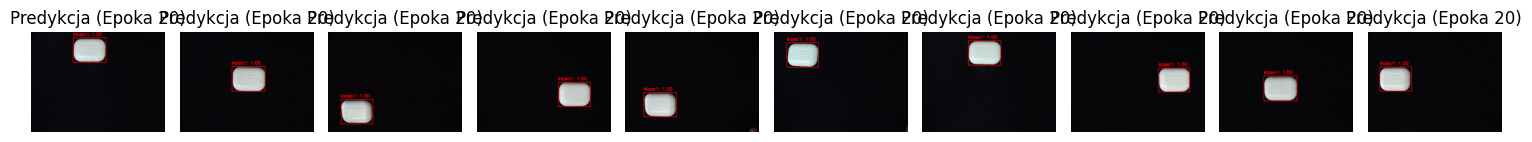

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
# Możesz potrzebować również:
# from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
# from torchvision.models.detection._utils import retrieve_out_channels
# import torchvision

# --- Założenia: Zmienne muszą być już zdefiniowane ---
# CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3']
# val_dataset = ... (Twój DataLoader.dataset)
# model = ... (Twój model z wczytanymi wagami)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------------------------------------------------

# Upewnij się, że model jest w trybie ewaluacji
model.eval()

# Liczba obrazów do przetestowania
NUM_TEST_IMAGES = 10
CONFIDENCE_THRESHOLD = 0.5 # Minimalna pewność wykrycia obiektu

# Pobieramy losowe indeksy ze zbioru walidacyjnego
if len(val_dataset) < NUM_TEST_IMAGES:
    NUM_TEST_IMAGES = len(val_dataset)

test_indices = random.sample(range(len(val_dataset)), NUM_TEST_IMAGES)
test_samples = [val_dataset[i] for i in test_indices]

# Przygotowujemy siatkę do wyświetlenia wyników
# Używamy math.ceil, aby obliczyć liczbę wierszy
rows = 1
cols = NUM_TEST_IMAGES
figsize = (15, 6 * rows) # Dostosuj rozmiar w zależności od liczby obrazów

fig, axes = plt.subplots(rows, cols, figsize=figsize)
# Jeśli mamy tylko jeden obraz, axes nie jest listą, więc to naprawiamy
if NUM_TEST_IMAGES == 1:
    axes = [axes]
elif NUM_TEST_IMAGES > 1:
    axes = axes.flatten() # Spłaszczamy do 1D dla łatwej iteracji

# Iterujemy przez wybrane próbki
for i, (img_tensor, _) in enumerate(test_samples):
    # Dodajemy wymiar "batcha" (wymagany przez model) i przenosimy na GPU
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor)

    # Przenosimy tensor obrazu z powrotem na CPU i konwertujemy do formatu wyświetlania (H, W, C)
    # Zwróć uwagę, że torchvision normalizuje obraz do zakresu 0-1, więc cofamy to do 0-255
    img_display = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 255).astype(np.uint8)

    # Przenosimy predykcje na CPU
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels_idx = prediction[0]['labels'].cpu().numpy()

    print(f"--- Obraz #{i+1} ---")
    found_object = False

    # Rysujemy ramki z pewnością powyżej progu
    for j, box in enumerate(pred_boxes):
        score = pred_scores[j]

        if score > CONFIDENCE_THRESHOLD:
            found_object = True
            xmin, ymin, xmax, ymax = box.astype(int)
            label_idx = pred_labels_idx[j]

            # Zapobiegamy błędowi indeksowania, jeśli etykieta jest poza zakresem CLASS_NAMES
            if label_idx < len(CLASS_NAMES):
                label_name = CLASS_NAMES[label_idx]
            else:
                label_name = f"Unknown ({label_idx})"

            print(f"  Wykryto '{label_name}' z pewnością {score:.2f} w ramce: [{xmin}, {ymin}, {xmax}, {ymax}]")

            # Używamy OpenCV do rysowania na obrazie
            # Ważne: cv2 wymaga obrazu w formacie BGR, jeśli wczytałeś go w RGB, musisz to uwzględnić
            # W torchvision standardowo pracujemy na RGB, więc rysujemy w RGB (255, 0, 0)
            cv2.rectangle(img_display, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

            # Rysowanie tekstu etykiety
            # Upewnij się, że tekst jest widoczny, nawet jeśli ramka jest blisko góry
            text_y = max(ymin - 10, 20)
            cv2.putText(img_display, f"{label_name}: {score:.2f}", (xmin, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    if not found_object:
        print(f"  Nie wykryto żadnego obiektu z pewnością > {CONFIDENCE_THRESHOLD}.")

    # Wyświetlamy obraz na odpowiedniej pozycji w siatce
    axes[i].imshow(img_display)
    axes[i].set_title(f"Predykcja (Epoka {epoch+1})")
    axes[i].axis('off')

# Upewniamy się, że wszystkie podploty są wykorzystane
for i in range(len(test_samples), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# --- NOWOŚĆ: Upewniamy się, że biblioteka jest zainstalowana ---
!pip install torchmetrics -q

from torchmetrics.detection import MeanAveragePrecision
from pprint import pprint

# Ustawiamy metrykę. Będziemy używać standardowego protokołu COCO.
metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)

# Ustawiamy model w tryb ewaluacji
model.eval()

print("Rozpoczynam ewaluację na całym zbiorze walidacyjnym...")

with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Generujemy predykcje
        predictions = model(images)

        # Przenosimy predykcje i etykiety na CPU, bo metryki działają na CPU
        preds_cpu = [{k: v.cpu() for k, v in p.items()} for p in predictions]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

        # Aktualizujemy stan metryki o wyniki z tego batcha
        metric.update(preds_cpu, targets_cpu)

# Obliczamy finalne wyniki
print("\nObliczanie finalnych metryk...")
results = metric.compute()

print("\n--- Wyniki Ewaluacji (mAP) ---")
pprint(results)

# Wyciągamy najważniejszą wartość - mAP@50 (najpopularniejsza metryka)
map_50 = results['map_50'].item()
print(f"\nKluczowa metryka mAP@50: {map_50:.4f}")
if map_50 > 0.75:
    print("Wynik jest bardzo dobry! Model jest precyzyjny.")
elif map_50 > 0.5:
    print("Wynik jest dobry. Model działa poprawnie.")
else:
    print("Wynik jest niski. Model może wymagać dłuższego treningu, więcej danych lub tuningu hiperparametrów.")

Rozpoczynam ewaluację na całym zbiorze walidacyjnym...

Obliczanie finalnych metryk...

--- Wyniki Ewaluacji (mAP) ---
{'classes': tensor([1, 2, 3], dtype=torch.int32),
 'map': tensor(0.9387),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.9387),
 'map_medium': tensor(-1.),
 'map_per_class': tensor([ 0.9387, -1.0000, -1.0000]),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.9500),
 'mar_10': tensor(0.9500),
 'mar_100': tensor(0.9500),
 'mar_100_per_class': tensor([ 0.9500, -1.0000, -1.0000]),
 'mar_large': tensor(0.9500),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}

Kluczowa metryka mAP@50: 1.0000
Wynik jest bardzo dobry! Model jest precyzyjny.


In [ ]:
# ==============================================================================
# --- POPRAWKA: Instalacja brakującej biblioteki ONNX ---
# ==============================================================================
!pip install onnx

# --- Reszta Twojego działającego kodu ---
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels

# Lista klas musi zawierać 4 elementy, tak jak podczas treningu.
CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3'] # <-- Twoje nazwy klas

MODEL_PATH_PTH = "/content/drive/MyDrive/best_object_detection_model.pth"
ONNX_MODEL_PATH = "/content/drive/MyDrive/ssdlite_model.onnx"

device = torch.device('cpu')
num_classes = len(CLASS_NAMES)

print(f"\nTworzenie modelu z domyślną architekturą (weights='DEFAULT')...")
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='DEFAULT')

print(f"Modyfikowanie głowicy dla {num_classes} klas...")
in_channels = retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer = nn.BatchNorm2d
model.head.classification_head = SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer)

print("Wczytywanie wytrenowanych wag...")
model.load_state_dict(torch.load(MODEL_PATH_PTH, map_location=device))
model.eval()
print("Wagi wczytane pomyślnie.")

dummy_input = torch.randn(1, 3, 320, 320, device='cpu')

print("Rozpoczynamie eksportu do formatu ONNX...")
try:
    torch.onnx.export(
        model,
        dummy_input,
        ONNX_MODEL_PATH,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['boxes', 'labels', 'scores']
    )
    print(f"\nModel został pomyślnie wyeksportowany do formatu ONNX!")
    print(f"Plik znajdziesz na Dysku Google pod ścieżką: {ONNX_MODEL_PATH}")

except Exception as e:
    print(f"\nWystąpił błąd podczas eksportu: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.5 MB/s eta 0:00:00

Tworzenie modelu z domyślną architekturą (weights='DEFAULT')...
Modyfikowanie głowicy dla 4 klas...
Wczytywanie wytrenowanych wag...
Wagi wczytane pomyślnie.
Rozpoczynamie eksportu do formatu ONNX...

Model został pomyślnie wyeksportowany do formatu ONNX!
Plik znajdziesz na Dysku Google pod ścieżką: /content/drive/MyDrive/ssdlite_model.onnx


In [ ]:
# Instalacja wymaganej biblioteki
!pip install -q ai-edge-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.6/477.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels
import ai_edge_torch.convert as aetc
import os

# --- Część 1: Odtworzenie architektury modelu ---

# Upewnij się, że ta lista jest identyczna z tą użytą podczas treningu
CLASS_NAMES = ["__background__", "object"]
num_classes = len(CLASS_NAMES)

# Ładowanie wstępnie wytrenowanego modelu
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None) # weights=None, bo wczytamy własne

# Modyfikacja głowicy klasyfikacyjnej - ten kod musi być identyczny jak w treningu
in_channels = retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer = nn.BatchNorm2d

model.head.classification_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=norm_layer
)



In [ ]:

    # --- Część 3: Konwersja modelu ---

    # Tworzymy przykładowy tensor wejściowy o oczekiwanym kształcie
    # (batch_size, channels, height, width)
    # Model SSDLite320 oczekuje wejścia 320x320
    example_input = torch.randn(1, 3, 320, 320).to(device)

    # Konwersja do formatu .pt (PyTorch JIT)
    try:
        print("\nRozpoczynam konwersję do formatu .pt (PyTorch JIT)...")
        traced_model = torch.jit.trace(model, example_input)
        traced_model.save("ssdlite_model.pt")
        print("✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'")
    except Exception as e:
        print(f"❌ Wystąpił błąd podczas konwersji do .pt: {e}")

    # Konwersja do formatu .tflite (AI Edge Torch)
    try:
        print("\nRozpoczynam konwersję do formatu .tflite...")
        # ai-edge-torch wymaga modelu w trybie eval() i przykładowego wejścia
        tflite_model = aetc.convert(model, example_input)

        # Zapisanie przekonwertowanego modelu do pliku
        with open("ssdlite_model.tflite", "wb") as f:
            f.write(tflite_model)
        print("✅ Pomyślnie zapisano model w formacie .tflite do pliku 'ssdlite_model.tflite'")
    except Exception as e:
        print(f"❌ Wystąpił błąd podczas konwersji do .tflite: {e}")

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels
import ai_edge_torch.convert as aetc
import os

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels
import ai_edge_torch.convert as aetc
import os
import traceback # POPRAWKA: Dodajemy import modułu traceback
from collections import namedtuple # POPRAWKA: Importujemy namedtuple

# --- Część 1: Odtworzenie DOKŁADNIE TEJ SAMEJ architektury modelu ---

CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3']
num_classes = len(CLASS_NAMES)

model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='DEFAULT')

in_channels = retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer = nn.BatchNorm2d

model.head.classification_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=norm_layer
)

Używane urządzenie: cuda
Pomyślnie załadowano wagi z pliku 'best_object_detection_model.pth'.


In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels
import ai_edge_torch.convert as aetc
import os
import traceback # POPRAWKA: Dodajemy import modułu traceback
from collections import namedtuple # POPRAWKA: Importujemy namedtuple

# --- Część 1: Odtworzenie DOKŁADNIE TEJ SAMEJ architektury modelu ---

CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3']
num_classes = len(CLASS_NAMES)

model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='DEFAULT')

in_channels = retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer = nn.BatchNorm2d

model.head.classification_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=norm_layer
)

# --- Część 2: Załadowanie wytrenowanych wag ---

WEIGHTS_FILE = 'best_object_detection_model.pth'

if not os.path.exists(WEIGHTS_FILE):
    print(f"Błąd: Plik z wagami '{WEIGHTS_FILE}' nie został znaleziony.")
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Używane urządzenie: {device}")

    model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
    model.to(device)
    model.eval()

    print(f"Pomyślnie załadowano wagi z pliku '{WEIGHTS_FILE}'.")

    # --- POPRAWKA: Definicja NamedTuple dla wyjścia ---
    # Służy do zdefiniowania stałej struktury wyjścia, akceptowanej przez JIT tracer
    DetectionOutput = namedtuple('DetectionOutput', ['boxes', 'labels', 'scores'])

    class DetectionModelWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, image_batch):
            predictions = self.model(image_batch)
            # Wyciągamy predykcje dla pierwszego obrazu
            output_dict = predictions[0]

            # POPRAWKA: Zwracamy NamedTuple zamiast słownika
            # Upewnij się, że klucze w output_dict są zgodne z polami NamedTuple
            return DetectionOutput(
                boxes=output_dict['boxes'],
                labels=output_dict['labels'],
                scores=output_dict['scores']
            )

    traceable_model = DetectionModelWrapper(model)
    traceable_model.eval()

    # --- Część 3: Konwersja modelu ---

    try:
        example_input = torch.randn(1, 3, 320, 320).to(device)

        # Konwersja do formatu .pt (PyTorch JIT)
        print("\nRozpoczynam konwersję do formatu .pt (PyTorch JIT)...")
        traced_model = torch.jit.trace(traceable_model, example_input)
        traced_model.save("ssdlite_model.pt")
        print("✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'")

        # Konwersja do formatu .tflite (AI Edge Torch)
        print("\nRozpoczynam konwersję do formatu .tflite...")
        # ai_edge_torch powinien akceptować NamedTuple
        tflite_model = aetc.convert(traceable_model, example_input)
        with open("ssdlite_model.tflite", "wb") as f:
            f.write(tflite_model)
        print("✅ Pomyślnie zapisano model w formacie .tflite do pliku 'ssdlite_model.tflite'")

    except Exception as e:
        print(f"❌ Wystąpił błąd podczas konwersji: {e}")
        # traceback.print_exc() został poprawiony i będzie teraz działać
        traceback.print_exc()

Używane urządzenie: cuda
Pomyślnie załadowano wagi z pliku 'best_object_detection_model.pth'.

Rozpoczynam konwersję do formatu .pt (PyTorch JIT)...
✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'

Rozpoczynam konwersję do formatu .tflite...
❌ Wystąpił błąd podczas konwersji: module 'ai_edge_torch.convert' has no attribute 'convert'


Traceback (most recent call last):
  File "/tmp/ipython-input-1940499522.py", line 84, in <cell line: 0>
    tflite_model = aetc.convert(traceable_model, example_input)
                   ^^^^^^^^^^^^
AttributeError: module 'ai_edge_torch.convert' has no attribute 'convert'


In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels
import ai_edge_torch # POPRAWKA: Zmieniamy sposób importu
import os
import traceback
from collections import namedtuple

# --- Część 1: Odtworzenie DOKŁADNIE TEJ SAMEJ architektury modelu ---

CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3']
num_classes = len(CLASS_NAMES)

model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='DEFAULT')

in_channels = retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer = nn.BatchNorm2d

model.head.classification_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=norm_layer
)

# --- Część 2: Załadowanie wytrenowanych wag ---

WEIGHTS_FILE = 'best_object_detection_model.pth'

if not os.path.exists(WEIGHTS_FILE):
    print(f"Błąd: Plik z wagami '{WEIGHTS_FILE}' nie został znaleziony.")
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Używane urządzenie: {device}")

    model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
    model.to(device)
    model.eval()

    print(f"Pomyślnie załadowano wagi z pliku '{WEIGHTS_FILE}'.")

    # --- Wrapper z NamedTuple (działał poprawnie) ---
    DetectionOutput = namedtuple('DetectionOutput', ['boxes', 'labels', 'scores'])

    class DetectionModelWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, image_batch):
            predictions = self.model(image_batch)
            output_dict = predictions[0]
            return DetectionOutput(
                boxes=output_dict['boxes'],
                labels=output_dict['labels'],
                scores=output_dict['scores']
            )

    traceable_model = DetectionModelWrapper(model)
    traceable_model.eval()

    # --- Część 3: Konwersja modelu ---

    try:
        example_input = torch.randn(1, 3, 320, 320).to(device)

        # Konwersja do formatu .pt (PyTorch JIT) - już działała
        print("\nRozpoczynam konwersję do formatu .pt (PyTorch JIT)...")
        traced_model = torch.jit.trace(traceable_model, example_input)
        traced_model.save("ssdlite_model.pt")
        print("✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'")

        # Konwersja do formatu .tflite (AI Edge Torch)
        print("\nRozpoczynam konwersję do formatu .tflite...")
        # POPRAWKA: Zmieniamy wywołanie funkcji
        tflite_model = ai_edge_torch.convert(traceable_model, example_input)
        with open("ssdlite_model.tflite", "wb") as f:
            f.write(tflite_model)
        print("✅ Pomyślnie zapisano model w formacie .tflite do pliku 'ssdlite_model.tflite'")

    except Exception as e:
        print(f"❌ Wystąpił błąd podczas konwersji: {e}")
        traceback.print_exc()

Używane urządzenie: cuda
Pomyślnie załadowano wagi z pliku 'best_object_detection_model.pth'.

Rozpoczynam konwersję do formatu .pt (PyTorch JIT)...
✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'

Rozpoczynam konwersję do formatu .tflite...
❌ Wystąpił błąd podczas konwersji: 'module' object is not callable


Traceback (most recent call last):
  File "/tmp/ipython-input-4033829487.py", line 79, in <cell line: 0>
    tflite_model = ai_edge_torch.convert(traceable_model, example_input)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'module' object is not callable


In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection._utils import retrieve_out_channels
import ai_edge_torch # POPRAWKA: Wracamy do podstawowego importu
import os
import traceback
from collections import namedtuple

# --- Część 1: Odtworzenie DOKŁADNIE TEJ SAMEJ architektury modelu ---
# Ta część jest w 100% poprawna.
CLASS_NAMES = ['__background__', 'klasa1', 'klasa2', 'klasa3']
num_classes = len(CLASS_NAMES)
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='DEFAULT')
in_channels = retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer = nn.BatchNorm2d
model.head.classification_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=norm_layer
)

# --- Część 2: Załadowanie wytrenowanych wag ---
# Ta część również jest poprawna.
WEIGHTS_FILE = 'best_object_detection_model.pth'
if not os.path.exists(WEIGHTS_FILE):
    print(f"Błąd: Plik z wagami '{WEIGHTS_FILE}' nie został znaleziony.")
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Używane urządzenie: {device}")
    model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
    model.to(device)
    model.eval()
    print(f"Pomyślnie załadowano wagi z pliku '{WEIGHTS_FILE}'.")

    # --- Wrapper z NamedTuple (działa poprawnie) ---
    DetectionOutput = namedtuple('DetectionOutput', ['boxes', 'labels', 'scores'])
    class DetectionModelWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        def forward(self, image_batch):
            predictions = self.model(image_batch)
            output_dict = predictions[0]
            return DetectionOutput(
                boxes=output_dict['boxes'],
                labels=output_dict['labels'],
                scores=output_dict['scores']
            )
    traceable_model = DetectionModelWrapper(model)
    traceable_model.eval()

    # --- Część 3: Konwersja modelu ---
    try:
        example_input = torch.randn(1, 3, 320, 320).to(device)

        # Konwersja do .pt (już działa)
        print("\nRozpoczynam konwersję do formatu .pt (PyTorch JIT)...")
        traced_model = torch.jit.trace(traceable_model, example_input)
        traced_model.save("ssdlite_model.pt")
        print("✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'")

        # Konwersja do .tflite
        print("\nRozpoczynam konwersję do formatu .tflite...")
        # OSTATECZNA POPRAWKA: Używamy pełnej ścieżki do funkcji 'convert'
        tflite_model = ai_edge_torch.convert.convert(traceable_model, example_input)
        with open("ssdlite_model.tflite", "wb") as f:
            f.write(tflite_model)
        print("✅ Pomyślnie zapisano model w formacie .tflite do pliku 'ssdlite_model.tflite'")

    except Exception as e:
        print(f"❌ Wystąpił błąd podczas konwersji: {e}")
        traceback.print_exc()

Używane urządzenie: cuda
Pomyślnie załadowano wagi z pliku 'best_object_detection_model.pth'.

Rozpoczynam konwersję do formatu .pt (PyTorch JIT)...
✅ Pomyślnie zapisano model w formacie .pt do pliku 'ssdlite_model.pt'

Rozpoczynam konwersję do formatu .tflite...
❌ Wystąpił błąd podczas konwersji: module 'ai_edge_torch.convert' has no attribute 'convert'


Traceback (most recent call last):
  File "/tmp/ipython-input-2782458365.py", line 69, in <cell line: 0>
    tflite_model = ai_edge_torch.convert.convert(traceable_model, example_input)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'ai_edge_torch.convert' has no attribute 'convert'
